In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import xlsxwriter

from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy 
from qiskit import QuantumCircuit, execute
from qiskit.tools.jupyter import *


In [2]:
tf.random.set_seed(2)
np.random.seed(2)

In [3]:
backend = BasicAer.get_backend("qasm_simulator")
shots = 4096

In [4]:
def show_function(x, y_before, y_after):
    
    figure, axis = plt.subplots(len(y_before), 2)

    figure.set_size_inches(12, 12)

    plt.figtext(0.23, 0.9, 'Before training', fontsize="xx-large")
    plt.figtext(0.66, 0.9, 'After training', fontsize="xx-large")

    for i in range(len(y_before)):
        axis[i][0].plot(x, y_before[i])
        axis[i][1].plot(x, y_after[i])

        axis[i][0].set_xlabel('x')
        axis[i][0].set_ylabel('y')
        axis[i][1].set_xlabel('x')
        axis[i][1].set_ylabel('y')

    plt.show()

In [5]:
def v1_circuit(x, theta):
    n = 2
    qc = QuantumCircuit(n, 1)
    
    qc.rx(theta = x, qubit = 0)
    qc.rx(theta = x**2, qubit = 1)
    qc.h(1)
    qc.cx(1, 0)
    
    qc.ry(theta = x*x*theta, qubit = 0)
    qc.ry(theta = x-theta, qubit = 1)
    
    qc.cx(0, 1)
    
    qc.measure(1, 0)
    
    return qc

In [6]:
class QuantumNeuron(keras.Model):
    
    def __init__(self, activation=lambda x : x, quantum_core=None):
        super().__init__()
        self.grad_eps = 0.01
#         define activation function if needed
        self.activation = activation
#     define quantum circuit which would be used
        self.quantum_core = quantum_core
        
    def build(self, input_shape):
#         create theta parameter
        self.theta = self.add_weight(shape=(1, 1), initializer=tf.random_normal_initializer(stddev=1.5))
    
    def forward_prop(self, inputs, theta):
        inner_out = inputs
#         run the given input through a circuit and calculate probabilities
        if not self.quantum_core is None:
            circuit = self.quantum_core(float(inputs[0, 0]), float(theta[0, 0]))
            results = execute(circuit, backend=backend, shots=shots).result()
            answer = results.get_counts()

            if(len(answer) == 1):
                a = list(answer)
                if a[0] == '1':
                    inner_out = 0.999
                else:
                    inner_out = 0.001
            else:    
                inner_out = (answer['1']/shots)
        
        inner_out = self.activation(inner_out)
        
        return inner_out
    
    def call(self, inputs):
        self.inputs = inputs
        self.prime()
        return self.forward_prop(inputs, self.theta)
    
    def train(self, dA, lr):
#         find dZ for that neuron and dTheta
        dZ = dA * self.f_z
        dTheta = dA * self.f_theta
        
#         update Theta
        self.theta = self.theta - lr * dTheta
        return dZ
        
#         prime calculation for z and theta
    def prime(self):
        f_theta_p = self.forward_prop(self.inputs, self.theta+self.grad_eps)
        f_theta_n = self.forward_prop(self.inputs, self.theta-self.grad_eps)      
        self.f_theta = (f_theta_p - f_theta_n)/(2*self.grad_eps)
        
        f_z_p = self.forward_prop(self.inputs+self.grad_eps, self.theta)
        f_z_n = self.forward_prop(self.inputs-self.grad_eps, self.theta)        
        self.f_z = (f_z_p - f_z_n)/(2*self.grad_eps)
    

In [7]:
class QuantumLayer(tf.keras.layers.Layer):
    
    def __init__(self, outputs=1, activation=lambda x : x, quantum_core=None, normalization=False):
        super().__init__()
        self.outputs = outputs
        self.normalization = normalization
# create neurons
        self.neurons = []
        for i in range(self.outputs):
            self.neurons.append(QuantumNeuron(activation=activation, quantum_core=quantum_core))
        
    def build(self, input_shape):
#         prepare weight matrix and bias
        self.w = tf.random.truncated_normal(shape=(input_shape[-1], self.outputs), stddev = 1.5)
        self.b = tf.zeros(shape=(self.outputs))
    
    def call(self, inputs):
        
        self.inputs = inputs 
#         calculate linear z value
        self.z = inputs @ self.w + self.b
        
#         normilization
        if self.normalization:
            if self.outputs > 1:
                self.z = (self.z - np.min(self.z))/(np.max(self.z)-np.min(self.z))
            else:
                self.z /= self.w.shape[0]
        
#         go through each neuron and calculate neuron activation, giving a corresponding part of z
        tmp = []
        for i in range(self.outputs):
            tmp.append(self.neurons[i](tf.constant((self.z[:, i]), shape=(inputs.shape[0], 1))))
        
        self.a = tf.reshape(tf.transpose(tf.Variable(tmp)), self.z.shape)
        
        return self.a
    
    def train(self, dA, lr_layer=0.01, lr_neuron=0.01):
        self.lr = lr_layer
        self.lr_neuron = lr_neuron
        
#         dZ is obtained from neurons
        dZ = self.train_neurons(dA)
        return self.train_weights(dZ)
    
    def train_neurons(self, dA):
#         the same as it was with forward prop, sent appropriate part of dA to each neuron training and obtain dZ
        tmp = []
        for i in range(self.outputs):
            tmp.append(self.neurons[i].train(tf.constant((dA[:, i]), shape=(dA.shape[0], 1)), self.lr_neuron))
            
        dZ = tf.reshape(tf.transpose(tf.Variable(tmp)), dA.shape)
        return dZ
    
    def train_weights(self, dZ):
#         calculate other gradients
        dW = (tf.transpose(dZ) @ self.inputs)/self.inputs.shape[0]    
        db = tf.reduce_sum(dZ, axis=0)/self.inputs.shape[0]    
        dA = dZ @ tf.transpose(self.w)
    
#     update parameters
        self.w = self.w - self.lr * tf.transpose(dW)
        self.b = self.b - self.lr * db
       
        return dA

#     function is used for illustrative purposes, allows to visualise neurons' activations
    def activation_show(self, x):
        outputs = []
        for i in range(self.outputs):
            tmp = np.array([])
            for value in (x):
                tmp = np.append(tmp, self.neurons[i](tf.expand_dims(value, axis=-1)))
                    
            if i == 0:
                outputs = np.array([tmp])
            else:
                outputs = np.append(outputs, [tmp], axis=0)
        
        return outputs
        

In [14]:
class Quantum_NN_Model(keras.Model):
    
    def __init__(self, l=[QuantumLayer(1)]):
        super().__init__()
        self.l = l
    
    def call(self, inputs):
        a = inputs
#         forward propagation from the first layer
        for layer in self.l:
            a = layer(a)
        return a
    
    def train(self, dAL, lr_layer=0.01, lr_neuron=0.01):
        dA = dAL
        
#         backpropagate, starting from the last layer
        for layer in reversed(self.l):
            dA = layer.train(dA, lr_layer, lr_neuron)
                    
    def activation_show(self, x):
        a = np.array([[]])
        first = True
        for layer in self.l:
            if first:
                a = layer.activation_show(x)
                first = False
            else:
                a = np.append(a, layer.activation_show(x), axis=0)
        
        return a


In [9]:
x_train = tf.random.uniform(shape=(200, 1), minval = 0, maxval = 1)
y_train = np.array([a > 0.5 for a in (x_train)], dtype=float)

x_test = tf.random.uniform(shape=(100, 1), minval = 0, maxval = 1)
y_test = np.array([a > 0.5 for a in (x_test)], dtype=float)

In [10]:
epochs = 10
learning_rate = 0.01
decay = 0.97

quantum_test = 0
classical_test = 0

In [11]:
quantum_nn = Quantum_NN_Model([
    QuantumLayer(2, quantum_core=v1_circuit),
    QuantumLayer(1, quantum_core=v1_circuit)
])

In [12]:
x_a = tf.expand_dims(np.arange(-2, 2.1, 0.1), axis=-1)
y_before = quantum_nn.activation_show(x_a)

In [13]:
q_history = np.array([[-1, -1]])
for epoch in range(epochs):
    accuracy = 0
    loss = 0
    
    lr = np.power(decay, epoch) * learning_rate
    
    for (x, y) in zip(x_train, y_train):
        pred = quantum_nn(tf.expand_dims(x, axis=0))
        
        loss = tf.losses.binary_crossentropy(pred, y)
        dAL = - (y/pred) + ((1-y)/(1-pred))

        out_pred = np.round(pred)

        if(out_pred == y):
            accuracy += 1
        
        quantum_nn.train(dAL, lr_layer=lr, lr_neuron=lr/10)
        
    loss = float(loss/len(x_train))
    accuracy = accuracy/len(x_train)
    q_history = np.append(q_history, [[accuracy, loss]], axis=0)
    print("Epoch : ", epoch, "Accuracy : ", accuracy, "Loss : ", loss, "Lr : ", lr)

Epoch :  0 Accuracy :  0.75 Loss :  0.021917285180107066 Lr :  0.01
Epoch :  1 Accuracy :  0.915 Loss :  0.008567323674354567 Lr :  0.0097
Epoch :  2 Accuracy :  0.91 Loss :  0.008284884432342878 Lr :  0.009408999999999999
Epoch :  3 Accuracy :  0.95 Loss :  0.00901922646157327 Lr :  0.00912673
Epoch :  4 Accuracy :  0.95 Loss :  0.01103395972125665 Lr :  0.008852928099999999
Epoch :  5 Accuracy :  0.945 Loss :  0.0076258595343156035 Lr :  0.008587340257
Epoch :  6 Accuracy :  0.945 Loss :  0.00820956730113976 Lr :  0.008329720049289998
Epoch :  7 Accuracy :  0.955 Loss :  0.007042151767491445 Lr :  0.008079828447811297
Epoch :  8 Accuracy :  0.955 Loss :  0.008642640805557683 Lr :  0.007837433594376959
Epoch :  9 Accuracy :  0.95 Loss :  0.006872688222284432 Lr :  0.007602310586545651


In [15]:
q_accuracy = 0
for (x, y) in zip(x_test, y_test):
    pred = quantum_nn(tf.expand_dims(x, axis=0))
        
    out_pred = np.round(pred)
        
    if(out_pred == y):
        q_accuracy += 1

q_accuracy = q_accuracy/len(x_test)
print("Quantum NN Test Accuracy : ", q_accuracy)
quantum_test += q_accuracy

Quantum NN Test Accuracy :  0.97


In [16]:
y_after = quantum_nn.activation_show(x_a)

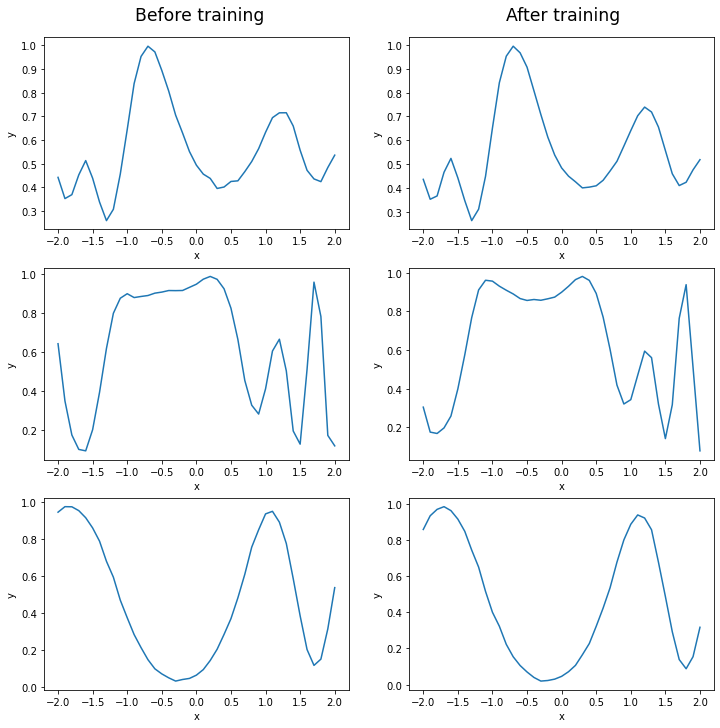

In [17]:
show_function(x_a, y_before, y_after)